## Shor Algoritması

In [1]:
import cirq
import numpy as np
from matplotlib import pyplot
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction

In [2]:
n_count = 8  # sayma kubitler
a = 7
N = 15
# 8 sayma + 4 kayit

all_qubits = cirq.LineQubit.range(n_count + 4)
count_qubits = all_qubits[:8]
register_qubits = all_qubits[8:]

shor_circuit = cirq.Circuit()

In [3]:
# Saymalara Hadamard uygula
shor_circuit.append(cirq.H.on_each(*count_qubits))

# Kayitci 4 kubiti bin(15) olarak ayarla.
shor_circuit.append(cirq.X(register_qubits[3]))
print(shor_circuit)

0: ────H───

1: ────H───

2: ────H───

3: ────H───

4: ────H───

5: ────H───

6: ────H───

7: ────H───

11: ───X───


In [4]:
# Kayıtçılar için Amod15 devresi 
def c_amod15(qubs, a, power):
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    
    U = cirq.Circuit()

    for iteration in range(power):
        if a in [2,13]:
            U.append(cirq.SWAP(qubs[0], qubs[1]))
            U.append(cirq.SWAP(qubs[1], qubs[2]))
            U.append(cirq.SWAP(qubs[2], qubs[3]))
        if a in [7,8]:
            U.append(cirq.SWAP(qubs[2], qubs[3]))
            U.append(cirq.SWAP(qubs[1], qubs[2]))
            U.append(cirq.SWAP(qubs[0], qubs[1]))
        if a == 11:
            U.append(cirq.SWAP(qubs[1], qubs[3]))
            U.append(cirq.SWAP(qubs[0], qubs[2]))
        if a in [7,11,13]:
            for q in range(4):
                U.append(cirq.X(qubs[q]))
    return U

In [5]:
class amod15_Gate(cirq.Gate):
    def __init__(self, a, power):
        super(amod15_Gate, self)
        self.a = a
        self.power = power

    def _num_qubits_(self):
        return 4

    def _decompose_(self, qubits):
        yield c_amod15(qubits, self.a, self.power)

    def _circuit_diagram_info_(self, args):
        return ["AmodN"] * self.num_qubits()

In [6]:
# Kontrollü-U kapılarını uygula.
for q in range(len(count_qubits)):
    shor_circuit.append(amod15_Gate(a, 2**q).controlled().on(all_qubits[q], *register_qubits))
print(shor_circuit)

0: ────H───@───────────────────────────────────────────────────────────────
           │
1: ────H───┼───────@───────────────────────────────────────────────────────
           │       │
2: ────H───┼───────┼───────@───────────────────────────────────────────────
           │       │       │
3: ────H───┼───────┼───────┼───────@───────────────────────────────────────
           │       │       │       │
4: ────H───┼───────┼───────┼───────┼───────@───────────────────────────────
           │       │       │       │       │
5: ────H───┼───────┼───────┼───────┼───────┼───────@───────────────────────
           │       │       │       │       │       │
6: ────H───┼───────┼───────┼───────┼───────┼───────┼───────@───────────────
           │       │       │       │       │       │       │
7: ────H───┼───────┼───────┼───────┼───────┼───────┼───────┼───────@───────
           │       │       │       │       │       │       │       │
8: ────────AmodN───AmodN───AmodN───AmodN───AmodN───AmodN───AmodN

In [7]:
iqft_operation = cirq.qft(*count_qubits, inverse=True, without_reverse=True)
shor_circuit.append(iqft_operation)
print(shor_circuit)

0: ────H───@───────────────────────────────────────────────────────────────qft[norev]^-1───
           │                                                               │
1: ────H───┼───────@───────────────────────────────────────────────────────#2──────────────
           │       │                                                       │
2: ────H───┼───────┼───────@───────────────────────────────────────────────#3──────────────
           │       │       │                                               │
3: ────H───┼───────┼───────┼───────@───────────────────────────────────────#4──────────────
           │       │       │       │                                       │
4: ────H───┼───────┼───────┼───────┼───────@───────────────────────────────#5──────────────
           │       │       │       │       │                               │
5: ────H───┼───────┼───────┼───────┼───────┼───────@───────────────────────#6──────────────
           │       │       │       │       │       │           

In [8]:
shor_circuit.append(cirq.measure(*count_qubits, key="C"))
print(shor_circuit)

0: ────H───@───────────────────────────────────────────────────────────────qft[norev]^-1───M('C')───
           │                                                               │               │
1: ────H───┼───────@───────────────────────────────────────────────────────#2──────────────M────────
           │       │                                                       │               │
2: ────H───┼───────┼───────@───────────────────────────────────────────────#3──────────────M────────
           │       │       │                                               │               │
3: ────H───┼───────┼───────┼───────@───────────────────────────────────────#4──────────────M────────
           │       │       │       │                                       │               │
4: ────H───┼───────┼───────┼───────┼───────@───────────────────────────────#5──────────────M────────
           │       │       │       │       │                               │               │
5: ────H───┼───────┼───────┼──

Text(0, 0.5, 'Adet')

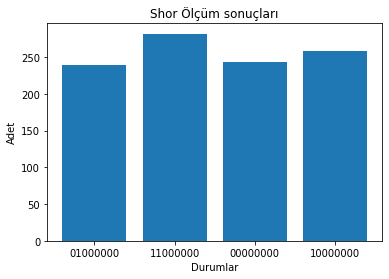

In [10]:
sim = cirq.Simulator()
results = sim.run(shor_circuit, repetitions=1024)
hist = dict()
for val in results.measurements["C"]:
    new_str = ""
    for s in val:
        new_str += str(s)
    try:
        hist[new_str] += 1
    except KeyError:
        hist[new_str] = 1
        
pyplot.bar(hist.keys(), hist.values())
pyplot.title("Shor Ölçüm sonuçları")
pyplot.xlabel("Durumlar")
pyplot.ylabel("Adet")

In [13]:
rows, measured_phases = [], []
for output in hist:
    decimal = int(output, 2)  # İkilik string -> ondalık sayı
    phase = decimal/(2**n_count)  # Alakalı eşdeğeri bul
    measured_phases.append(phase)
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
               f"{decimal}/{2**n_count} = {phase:.2f}"])
headers=["Kayıtçı Değerleri", "Faz"]
df = pd.DataFrame(rows, columns=headers)
print(df)

          Kayıtçı Değerleri             Faz
0  01000000(bin) =  64(dec)   64/256 = 0.25
1  11000000(bin) = 192(dec)  192/256 = 0.75
2  00000000(bin) =   0(dec)    0/256 = 0.00
3  10000000(bin) = 128(dec)  128/256 = 0.50


In [15]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])

headers=["Faz", "Kalan", "Tahmin: r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

    Faz Kalan  Tahmin: r
0  0.25   1/4          4
1  0.75   3/4          4
2  0.00   0/1          1
3  0.50   1/2          2


In [17]:
# En çok rastlanan priyot 4.
r = 4
guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
print(guesses)

[3, 5]
